In [ ]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
from pickle import load
import numpy as np
from numpy.random import rand
from numpy.random import shuffle

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.losses import *
from tensorflow.keras import optimizers

In [ ]:
from nltk.translate.bleu_score import sentence_bleu as bleu

In [ ]:
!wget http://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip

--2020-06-18 12:19:21--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.24.109.196, 104.24.108.196, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4781548 (4.6M) [application/zip]
Saving to: ‘spa-eng.zip.1’

spa-eng.zip.1       100%[===================>]   4.56M  4.90MB/s    in 0.9s    

2020-06-18 12:19:22 (4.90 MB/s) - ‘spa-eng.zip.1’ saved [4781548/4781548]



In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t')[:2] for line in  lines]
	return pairs
# clean a list of lines
def cleaned_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars form each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from shutil import copyfile
copyfile("/content/drive/My Drive/en_es_data/train.txt","/content/spa.txt")

'/content/spa.txt'

In [ ]:
# load dataset
filename = 'spa.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = cleaned_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'english-spanish.pkl')
# spot check
for i in range(3):
	print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: english-spanish.pkl
[thank you so much chris and its truly a great honor to have the opportunity to come to this stage twice im extremely grateful] => [muchas gracias chris y es en verdad un gran honor tener la oportunidad de venir a este escenario por segunda vez estoy extremadamente agradecido]
[i have been blown away by this conference and i want to thank all of you for the many nice comments about what i had to say the other night] => [he quedado conmovido por esta conferencia y deseo agradecer a todos ustedes sus amables comentarios acerca de lo que tena que decir la otra noche]
[and i say that sincerely partly because mock sob i need that put yourselves in my position] => [y digo eso sinceramente en parte porque sollozos fingidos lo necesito pnganse en mi posicin]


In [ ]:
k = 0
k1 = 0
for i in range(0,len(clean_pairs)):
	# print(clean_pairs[i],len(clean_pairs[i]))
	if k<len(clean_pairs[i][0].split(" ")):
		k = len(clean_pairs[i,0].split(" "))
	if k1<len(clean_pairs[i][1].split(" ")):
		k1 = len(clean_pairs[i,1].split(" "))
print(k,k1)

59 59


In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

#EVALUATION FUNCTIONS
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
  predict = model.predict(source, verbose=0)[0]
  integers = []
  for pred in predict:
    integers.append(np.argmax(pred))
  target = []
  for i in integers:
    word = word_for_id(i, tokenizer)
    if word is None:
      break
    target.append(word)
  return ' '.join(target)

def performance(model):
  sam = -1
  b1=0
  b2=0
  b3=0
  b4=0

  min_b1=2
  min_b2=2
  min_b3=2
  min_b4=2

  count = 0
  check=0
  for j in range(0,int(len(testX)/40)):
    count = count+1
    sam =sam +10
    actual=[]
    predicted =[]
    source = []
    print(count)
    x_input11=testX[sam].reshape(1,eng_length)
    x_input21=np.zeros((1,es_length)) 
    for i in range(0,es_length):
      output = model.predict([x_input11,x_input21])
      out1=np.argmax(output,axis=2)
      a = out1[0,i]
      if i !=es_length-1:
        x_input21[0,i+1]=a
      if a==0:
        break
    prediction = x_input21[0].tolist()
    prediction.append(a)

    for w in testX[sam]:
      try:
        source.append(eng_tokenizer.index_word[w])
      except:
        source.append('')
    for w in prediction[1:]:
      try:
        predicted.append(es_tokenizer.index_word[w])
      except:
        predicted.append('-')
    for w in testY[sam]:
      try:
        actual.append(es_tokenizer.index_word[w])
      except: 
        actual.append('-')
    source = " ".join(source)
    actual = " ".join(actual)
    predicted = " ".join(predicted)
    if count<10:
      print("source: %s" % source)
      print("actual: %s" % actual)
      print("predicted: %s" % predicted)

  # try:
    che = bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    if (che<min_b1):
      min_b1 =che
    b1=b1+ che

    che = bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    if (che<min_b2):
      min_b2 =che
    b2=b2+ che

    che = bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    if (che<min_b3):
      min_b3 =che
    b3=b3+ che


    che = bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    if (che<min_b4):
      min_b4 =che
    b4=b4+ che
    check = check + 1
  # except:
    # pass
  print(check)
  print(b1/check,b2/check,b3/check,b4/check)
  print(min_b1,min_b2,min_b3,min_b4)

In [ ]:
f = open("spa.txt","r")
count = 0
for line in f:
  count = count + 1
print(count)

216617


In [ ]:
# load dataset
raw_dataset = load_clean_sentences('english-spanish.pkl')

# reduce dataset size
n_sentences = 100000
dataset = raw_dataset[:n_sentences, :]
for i in range(0,n_sentences):
  a = dataset[i,0].split()
  a = " ".join(e for e in a)
  dataset[i,0] = a
  a = dataset[i,1].split()
  a = " ".join(e for e in a)
  dataset[i,1] = a
# random shuffle
shuffle(dataset)
# split into train/test
lim = int(n_sentences*0.95)
train, test = dataset[:lim], dataset[lim:]
# save
save_clean_data(dataset, 'english-spanish-both.pkl')
save_clean_data(train, 'english-spanish-train.pkl')
save_clean_data(test, 'english-spanish-test.pkl')

Saved: english-spanish-both.pkl
Saved: english-spanish-train.pkl
Saved: english-spanish-test.pkl


Similar operations as above but this time we omit the sentences that are too long

In [ ]:
# # load dataset
# raw_dataset = load_clean_sentences('english-spanish.pkl')

# # reduce dataset size
# n_sentences = 100000
# dataset = raw_dataset
# for i in range(0,len(dataset)) and i<n_sentences:
#   a = dataset[i,0].split()
#   a = " ".join(e for e in a)
#   dataset[i,0] = a
#   a = dataset[i,1].split()
#   a = " ".join(e for e in a)
#   dataset[i,1] = a
# # random shuffle
# shuffle(dataset)
# # split into train/test
# lim = int(n_sentences*0.95)
# train, test = dataset[:lim], dataset[lim:]
# # save
# save_clean_data(dataset, 'english-spanish-both.pkl')
# save_clean_data(train, 'english-spanish-train.pkl')
# save_clean_data(test, 'english-spanish-test.pkl')

In [ ]:
dataset = load_clean_sentences('english-spanish-both.pkl')
train = load_clean_sentences('english-spanish-train.pkl')
test = load_clean_sentences('english-spanish-test.pkl')

In [ ]:
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare german tokenizer
es_tokenizer = create_tokenizer(dataset[:, 1])
es_vocab_size = len(es_tokenizer.word_index) + 1
es_length = max_length(dataset[:, 1])
print('Spanish Vocabulary Size: %d' % es_vocab_size)
print('Spanish Max Length: %d' % (es_length))

English Vocabulary Size: 39485
English Max Length: 59
Spanish Vocabulary Size: 56098
Spanish Max Length: 59


107.0


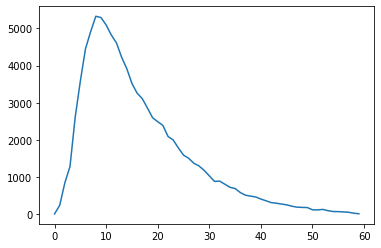

In [ ]:
import matplotlib.pyplot as plt  
a = np.zeros((60,1))
for line in train[:,0]:
  a[len(line.split())] = a[len(line.split())] + 1
plt.plot(a)
print(np.sum(a[57:]))

In [ ]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(es_tokenizer, es_length, train[:, 1])
# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(es_tokenizer, es_length, test[:, 1])

In [ ]:
train_outY = trainY
for index in range(0,len(train_outY)):
  k = np.asarray([0]+list(train_outY[index,:-1]))
  train_outY[index] = k
test_outY = testY
for index in range(0,len(test_outY)):
  k = np.asarray([0]+list(test_outY[index,:-1]))
  test_outY[index] = k
trainY = encode_sequences(es_tokenizer, es_length, train[:, 1])
testY = encode_sequences(es_tokenizer, es_length, test[:, 1])
train_outY.shape,test_outY.shape

((95000, 59), (5000, 59))

In [ ]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units,dropout_rate,eng_embed_dim,es_embed_dim):
  x_input1 = Input(shape=(src_timesteps,))
  x_input2 = Input(shape=(tar_timesteps,)) 

  x=Embedding(input_dim=src_vocab,output_dim=eng_embed_dim,embeddings_initializer="uniform",name = "embedding_en")(x_input1)
  x1=Embedding(input_dim=tar_vocab,output_dim=es_embed_dim,embeddings_initializer="uniform",name = "embedding_es")(x_input2)

  x_enc,state_h,state_c = LSTM(n_units,return_state = True,recurrent_dropout = dropout_rate)(x)
  enc_state = [state_h,state_c]


  dec = LSTM(n_units,return_sequences=True,dropout=dropout_rate)(x1,initial_state = enc_state)
  out = Dense(tar_vocab,activation='softmax')(dec)
  main_model = Model([x_input1,x_input2],out)

  return main_model

def create_att_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units,dropout_rate,eng_embed_dim,es_embed_dim):
  x_input1 = Input(shape=(src_timesteps,))
  x_input2 = Input(shape=(tar_timesteps,)) 

  x=Embedding(input_dim=src_vocab+1,output_dim=eng_embed_dim,embeddings_initializer="uniform",name = "embedding_en")(x_input1)
  x1=Embedding(input_dim=tar_vocab+1,output_dim=es_embed_dim,embeddings_initializer="uniform",name = "embedding_es")(x_input2)

  x = Bidirectional(LSTM(int(n_units/2),recurrent_dropout=dropout_rate,return_sequences=True))(x)
  x_enc,state_h,state_c = LSTM(n_units,return_state = True,return_sequences=True,recurrent_dropout = dropout_rate)(x)
  enc_state = [state_h,state_c]

  dec = LSTM(n_units,return_sequences=True,dropout=dropout_rate)(x1,initial_state = enc_state)
  dec = LSTM(n_units,return_sequences=True,dropout=dropout_rate)(dec)
  # dec = Attention()([dec,x_enc])
  # out = Dense(tar_vocab,activation='softmax')(dec)

  # luong attention
  attention = dot([dec, x_enc], axes=[2, 2])
  attention = Activation('softmax', name='attention')(attention)

  context = dot([attention, x_enc], axes=[2,1])

  decoder_combined_context = concatenate([context, dec])

  output = TimeDistributed(Dense(2*n_units, activation="tanh"))(decoder_combined_context)
  out = TimeDistributed(Dense(tar_vocab, activation="softmax"))(output)

  main_model = Model([x_input1,x_input2],out)

  return main_model

In [ ]:
n_units = 256
eng_embed_dim = 256
es_embed_dim = eng_embed_dim
dropout_rate = 0.2
model = create_att_model(eng_vocab_size, es_vocab_size, eng_length, es_length, n_units,dropout_rate,eng_embed_dim,es_embed_dim)
# model = create_att_model(eng_vocab_size, es_vocab_size, eng_length, es_length, n_units,dropout_rate,eng_embed_dim,es_embed_dim)
# model = create_bi_model(eng_vocab_size, es_vocab_size, eng_length, es_length, n_units,dropout_rate,eng_embed_dim,es_embed_dim)
# model = create_model(eng_vocab_size, es_vocab_size, eng_length, es_length, n_units,dropout_rate,eng_embed_dim,es_embed_dim)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
embedding_en (Embedding)        (None, 59, 256)      10108416    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 59)]         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 59, 256)      394240      embedding_en[0][0]               
______________________________________________________________________________________________

In [ ]:
%cd /content/
version = "0"
filename = 'model'+str(n_units)+'_'+str(version)+'.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
los = SparseCategoricalCrossentropy()
# model = load_model('model100_0.h5')
opt = optimizers.Adam(lr=0.001)
model.compile(loss=los,optimizer=opt,metrics=['accuracy'])
model.fit([trainX,train_outY], trainY, epochs=30, batch_size=256, validation_data=([testX,test_outY], testY), callbacks=[checkpoint], verbose=1)

/content
Epoch 1/30
372/372 [==============================] - ETA: 0s - loss: 0.8073 - accuracy: 0.8574
Epoch 00001: val_loss improved from inf to 0.97146, saving model to model256_0.h5
372/372 [==============================] - 876s 2s/step - loss: 0.8073 - accuracy: 0.8574 - val_loss: 0.9715 - val_accuracy: 0.8502
Epoch 2/30
372/372 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.8684
Epoch 00002: val_loss improved from 0.97146 to 0.94072, saving model to model256_0.h5
372/372 [==============================] - 873s 2s/step - loss: 0.7195 - accuracy: 0.8684 - val_loss: 0.9407 - val_accuracy: 0.8553
Epoch 3/30
372/372 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.8780
Epoch 00003: val_loss improved from 0.94072 to 0.92377, saving model to model256_0.h5
372/372 [==============================] - 874s 2s/step - loss: 0.6512 - accuracy: 0.8780 - val_loss: 0.9238 - val_accuracy: 0.8580
Epoch 4/30
 12/372 [..............................] -

KeyboardInterrupt: ignored

In [ ]:
lim = 100000
opt = optimizers.Adam(lr=0.0001)
# model = load_model('model150_0.h5')
model.compile(loss=los,optimizer=opt,metrics=['accuracy'])

model.fit([trainX[:lim],train_outY[:lim]], trainY[:lim], epochs=7, batch_size=256, validation_data=([testX,test_outY], testY), callbacks=[checkpoint], verbose=1)

Epoch 1/7
372/372 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.8918
Epoch 00001: val_loss improved from 0.92377 to 0.89894, saving model to model256_0.h5
372/372 [==============================] - 881s 2s/step - loss: 0.5628 - accuracy: 0.8918 - val_loss: 0.8989 - val_accuracy: 0.8617
Epoch 2/7
372/372 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.8944
Epoch 00002: val_loss improved from 0.89894 to 0.89599, saving model to model256_0.h5
372/372 [==============================] - 877s 2s/step - loss: 0.5481 - accuracy: 0.8944 - val_loss: 0.8960 - val_accuracy: 0.8621
Epoch 3/7
166/372 [============>.................] - ETA: 7:55 - loss: 0.5394 - accuracy: 0.8958

KeyboardInterrupt: ignored

In [ ]:
%cd /content/
model = load_model("model256_0.h5")
performance(model)

/content
1
source: but whats happened is our technology has removed the checks and balances on our population growth                                           
actual: pero lo que ha ocurrido es que nuestra tecnologa ha quitado los controles y equilibrios en el crecimiento popular - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
predicted: pero lo que ha pasado es nuestra tecnologa se ha quitado la carga y la lucha en nuestro crecimiento de la poblacin - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
2


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


source: you know hes thinking what am i getting myself into                                                 
actual: ustedes sabenl estaba pensando en qu me estoy involuncrando - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
predicted: saben l es pensar qu estoy haciendo - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
3
source: and that was something that i went through you know and im still going through                                            
actual: y que fue algo por lo que pas saben y que an lo estoy pasando - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
predicted: y eso fue algo que fui a travs de ustedes saben y yo sigo adelante - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
4
source: the president needs to stand up and say at the end of a healthcare reform debate our goal as a country is

In [ ]:
lim = 100000
opt = optimizers.Adam(lr=0.0001)
model = load_model('model150_0.h5')
model.compile(loss=los,optimizer=opt,metrics=['accuracy'])

model.fit([trainX[:lim],train_outY[:lim]], trainY[:lim], epochs=10, batch_size=256, validation_data=([testX,test_outY], testY), callbacks=[checkpoint], verbose=1)

Epoch 1/10
372/372 [==============================] - ETA: 0s - loss: 0.5596 - accuracy: 0.8929
Epoch 00001: val_loss improved from 0.90288 to 0.89247, saving model to model150_0.h5
372/372 [==============================] - 766s 2s/step - loss: 0.5596 - accuracy: 0.8929 - val_loss: 0.8925 - val_accuracy: 0.8631
Epoch 2/10
372/372 [==============================] - ETA: 0s - loss: 0.5506 - accuracy: 0.8946
Epoch 00002: val_loss improved from 0.89247 to 0.88979, saving model to model150_0.h5
372/372 [==============================] - 769s 2s/step - loss: 0.5506 - accuracy: 0.8946 - val_loss: 0.8898 - val_accuracy: 0.8635
Epoch 3/10
372/372 [==============================] - ETA: 0s - loss: 0.5455 - accuracy: 0.8954
Epoch 00003: val_loss did not improve from 0.88979
372/372 [==============================] - 766s 2s/step - loss: 0.5455 - accuracy: 0.8954 - val_loss: 0.8900 - val_accuracy: 0.8635
Epoch 4/10
301/372 [=======================>......] - ETA: 2:23 - loss: 0.5412 - accuracy: 0.

In [ ]:
%cd /content/
model = load_model("model150_0.h5")
performance(model)

In [ ]:
test_string = "hello i will dance"
t = np.asarray(test_string,dtype='<U275').reshape((1,))
tX = encode_sequences(eng_tokenizer, eng_length, t)


In [ ]:
x_input11=tX.reshape(1,eng_length)
x_input21=np.zeros((1,es_length)) 
predicted = []
for i in range(0,es_length):
  output = model.predict([x_input11,x_input21])
  out1=np.argmax(output,axis=2)
  a = out1[0,i]
  if i !=es_length-1:
    x_input21[0,i+1]=a
  if a==0:
    break
prediction = x_input21[0].tolist()
prediction.append(a)
for w in prediction[1:]:
  try:
    predicted.append(es_tokenizer.index_word[w])
  except:
    predicted.append('')
prediction = " ".join(predicted)
print(prediction)

hola yo dedo                                                        


In [ ]:
for t in out1[0]:
  try:
    print(es_tokenizer.index_word[t],end=" ")
  except:
    pass

hola yo dedo 

In [ ]:
####BEST ONE BY FAR###############
model = load_model("model100_0.h5")
print("model name  : model100_0.h5")
print(model.summary())
performance(model)
model = load_model("model100_1.h5")
print("model name  : model100_1.h5")
print(model.summary())
performance(model)
model = load_model("model100_2.h5")
print("model name  : model100_2.h5")
print(model.summary())
performance(model)
model = load_model("model50_2.h5")
print("model name  : model50_2.h5")
print(model.summary())
performance(model)

model name  : model200_0.h5
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding_en (Embedding)        (None, 9, 100)       851700      input_15[0][0]                   
__________________________________________________________________________________________________
embedding_es (Embedding)        (None, 14, 100)      1604300     input_16[0][0]                   
________________________________________________________________

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


source: i think hes a great writer   
actual: pienso que es un gran escritor - - - - - - - -
predicted: creo que es una gran escritor - - - - - - - -
source: choose the one you like    
actual: elige el que te guste - - - - - - - - -
predicted: elige usted el que quiere - - - - - - - - -
source: he knows how to tell lies   
actual: el sabe decir mentiras - - - - - - - - - -
predicted: el sabe como decir - - - - - - - - - -
source: he flew a kite     
actual: el elevo un volantin - - - - - - - - - -
predicted: el atrapo un volantin - - - - - - - - - -
source: i want tom to win    
actual: quiero que tom gane - - - - - - - - - -
predicted: quiero que tom ganara - - - - - - - - - -
source: ill probably use it again    
actual: probablemente lo voy a usar de nuevo - - - - - - -
predicted: yo solia haber leido hace - - - - - - - - -
source: you need to be there    
actual: necesitas estar ahi - - - - - - - - - - -
predicted: necesitas estar ahi - - - - - - - - - - -
source: i found you     

In [ ]:
from shutil import copyfile
%cd /content/drive/My\ Drive/
!mkdir cs224n_nmt
copyfile("/content/model256_0.h5","/content/drive/My Drive/cs224n_nmt/model256_0.h5")

/content/drive/My Drive
mkdir: cannot create directory ‘cs224n_nmt’: File exists


'/content/drive/My Drive/cs224n_nmt/model256_0.h5'